# Parking spot classification
<span style="color:grey">Goal<span style="color:grey">:  

Input: Cropped images of single parking spots  
Output: Classification as occupied or empty.

In [2]:
import os
import shutil
import sys
sys.path.append('../')

import numpy as np
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from torchvision.datasets import ImageFolder #responsible for loading images from train and test folders
from torch.utils.data import DataLoader, random_split, ConcatDataset # Definition of iterable
from torchvision import transforms, models # Provides image transformations
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


import mlflow.pytorch
import mlflow

from modeling.config import *

## Set-up MLFlow

In [3]:
## Setting up MLFlow

TRACKING_URI = open("../.mlflow_uri").read().strip()
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.end_run()
# client = MlflowClient(tracking_uri=TRACKING_URI)

# all_experiments = client.search_experiments()

# print(all_experiments)


# Preprocess data

Create a folder with pictures structured by label: Empty or Occupied. Date is removed.


In [8]:
destpath_dic = {'PUC_sunny':'../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/', 
                'PUC_cloudy':'../data/PKLot/PKLotSegmented_rearranged/PUC/Cloudy',
                'PUC_rainy':'../data/PKLot/PKLotSegmented_rearranged/PUC/Rainy/',
                '04_sunny':'../data/PKLot/PKLotSegmented_rearranged/UFPR04/Sunny',
                '04_cloudy':'../data/PKLot/PKLotSegmented_rearranged/UFPR04/Cloudy',
                '04_rainy':'../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy',
                '05_sunny':'../data/PKLot/PKLotSegmented_rearranged/UFPR05/Sunny',
                '05_cloudy':'../data/PKLot/PKLotSegmented_rearranged/UFPR05/Cloudy',
                '05_rainy':'../data/PKLot/PKLotSegmented_rearranged/UFPR05/Rainy'}

#destpath = '../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/'
#destpath = '../data/PKLot/PKLotSegmented_rearranged/PUC/Rainy/'
#destpath = '../data/PKLot/PKLotSegmented_rearranged/PUC/Cloudy'
#destpath = '../data/PKLot/PKLotSegmented_rearranged/UFPR04/Sunny'
#destpath = '../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy'
#destpath = '../data/PKLot/PKLotSegmented_rearranged/UFPR04/Cloudy'
#destpath = '../data/PKLot/PKLotSegmented_rearranged/UFPR05/Sunny'
#destpath = '../data/PKLot/PKLotSegmented_rearranged/UFPR05/Rainy'
destpath = '../data/PKLot/PKLotSegmented_rearranged/UFPR05/Cloudy'

#create_labelfolder(destpath)

In [89]:
def find_raw_path(path):
    substring = path.split('/')
    substring[3]=substring[3].removesuffix('_rearranged')
    result = '/'.join(substring)
    return result


In [44]:
# Create the label folder.
def create_labelfolder(destpath):
    '''
    Creates the label paths.
    Input: Destination folder.
    '''
    if not os.path.exists(os.path.join(destpath,'Empty')):
        os.makedirs(os.path.join(destpath,'Empty'))
    if not os.path.exists(os.path.join(destpath,'Occupied')):
        os.makedirs(os.path.join(destpath,'Occupied'))

In [65]:
def copy_files_to(destpath):
    rawpath = find_raw_path(destpath)
    daylist = os.listdir(rawpath)
    labels = ['Empty','Occupied']
    for day in daylist:
        for label in labels:
            daypath = os.path.join(rawpath,day)
            path = os.path.join(daypath,label)
            path_to =  os.path.join(destpath,label)
            if os.path.exists(path):
                filelist = os.listdir(path)
                for file in filelist:
                    filepath = os.path.join(path,file)
                    shutil.copy(filepath,path_to)
            else:
                print(f'path {path} empty')

                

In [103]:
#copy_files_to(destpath)

path ../data/PKLot/PKLotSegmented/UFPR05/Cloudy/.DS_Store/Empty empty
path ../data/PKLot/PKLotSegmented/UFPR05/Cloudy/.DS_Store/Occupied empty
path ../data/PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-03/Occupied empty
path ../data/PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-02/Occupied empty


# EDA

- Check number of pictures per dataset.
- Check size of pictures
- Distribution with weather.

In [4]:
emptylist= os.listdir(os.path.join(DATASET_PATH,'Empty'))
occupiedlist = os.listdir(os.path.join(DATASET_PATH,'Occupied'))
labels = ['Empty','Occupied']

Image shape: (720, 1280, 3)
Image data type: uint8


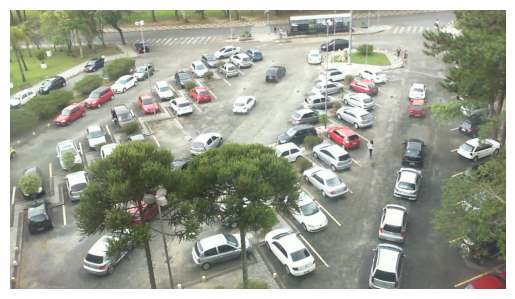

In [ ]:
# Have a look at the images
img_path = '../data/PKLot/PKLot/UFPR04/Sunny/2012-12-07/'

imge = '2012-12-07_17_22_25.jpg'
imge_xml = '2012-12-07_17_22_25.xml'

img = Image.open(img_path+imge)
# Read the image
imgocv = cv2.imread(img_path+imge)

# Display information about the image
print(f"Image shape: {imgocv.shape}")
print(f"Image data type: {imgocv.dtype}")

# Convert the image from BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(imgocv, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)

plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# Interpret the XML file
# Specify the path to your XML file
xml_file_path = img_path+imge_xml

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Iterate over each space in the parking lot
for space_element in root.findall('.//space'):
    space_id = space_element.get('id')
    occupied = space_element.get('occupied')

    rotated_rect = space_element.find('.//rotatedRect')
    center = rotated_rect.find('center')
    center_x = center.get('x')
    center_y = center.get('y')

    contour = space_element.find('.//contour')
    points = contour.findall('point')

    # Process the extracted information
    print(f"Space ID: {space_id}")
    print(f"Occupied: {occupied}")
    print(f"Center: ({center_x}, {center_y})")

    # Extract and print contour points
    print("Contour points:")
    for point in points:
        point_x = point.get('x')
        point_y = point.get('y')
        print(f"  Point: ({point_x}, {point_y})")

    print("\n---\n")

Space ID: 1
Occupied: 1
Center: (724, 623)
Contour points:
  Point: (720, 549)
  Point: (805, 665)
  Point: (715, 698)
  Point: (644, 582)

---

Space ID: 2
Occupied: 1
Center: (774, 511)
Contour points:
  Point: (769, 451)
  Point: (849, 534)
  Point: (789, 586)
  Point: (701, 489)

---

Space ID: 3
Occupied: 1
Center: (812, 445)
Contour points:
  Point: (806, 399)
  Point: (879, 466)
  Point: (823, 499)
  Point: (747, 425)

---

Space ID: 4
Occupied: 1
Center: (836, 368)
Contour points:
  Point: (829, 323)
  Point: (900, 383)
  Point: (862, 430)
  Point: (771, 356)

---

Space ID: 5
Occupied: 1
Center: (865, 317)
Contour points:
  Point: (850, 282)
  Point: (918, 322)
  Point: (891, 368)
  Point: (810, 311)

---

Space ID: 6
Occupied: 1
Center: (885, 266)
Contour points:
  Point: (863, 231)
  Point: (938, 271)
  Point: (909, 309)
  Point: (832, 262)

---

Space ID: 7
Occupied: 1
Center: (903, 226)
Contour points:
  Point: (884, 194)
  Point: (956, 231)
  Point: (928, 265)
  Point: (8

/var/folders/2n/6g_5z31502qdn2b96gy2sss00000gn/T/ipykernel_92479/2948390238.py:22: RuntimeWarning: invalid value encountered in cast
  transformed_image = (transformed_image.numpy().transpose((1, 2, 0)) * 255).astype('uint8')


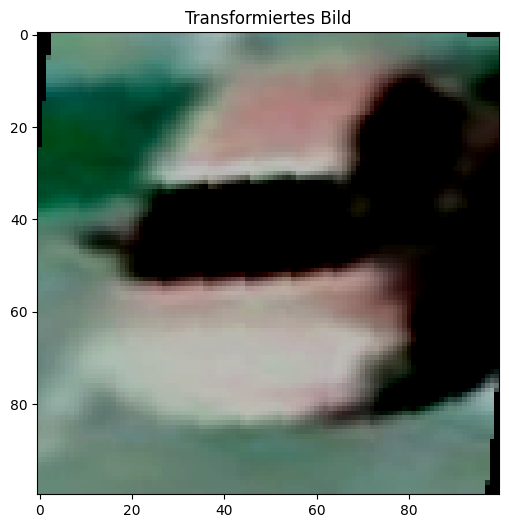

In [7]:
# Plotting the transformed image.

image_path = '../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/Occupied/2012-09-11_15_16_58#001.jpg'
image = cv2.imread(image_path)

# Definition of Transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128), interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transformed_image = data_transform(image)

# Transformation of Tensor to NumPy-Array and setting the values back in [0, 255]
transformed_image = (transformed_image.numpy().transpose((1, 2, 0)) * 255).astype('uint8')

# Bild anzeigen
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image)
plt.title('Transformiertes Bild')
plt.show()

In [5]:
print(len(emptylist))
len(occupiedlist)


111626


96761

<Axes: >

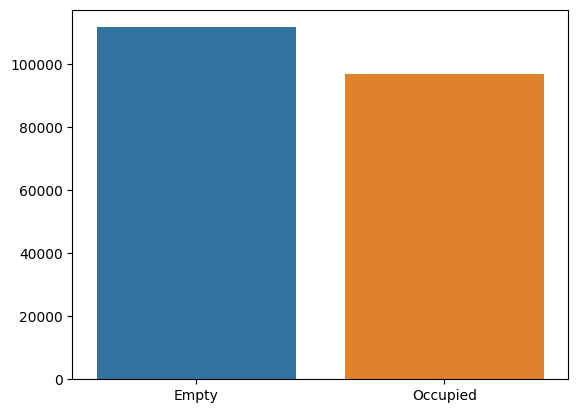

In [6]:
# Numbers of classes almost equal in sunny datasets.
sns.barplot(x=labels, y =[len(emptylist), len(occupiedlist)])

# Observation:
# Lots of data. Most pictures duplicates because created from video. Think during training how to reduce data amount.


In [ ]:
# Open folder with pictures
# Adjust path to your path
images_folder = os.path.join('..', 'data', 'model', 'PUC', 'Sunny', 'Empty')

# List with all pictures
image_files = os.listdir(images_folder)

# Determine the smalles image size
smallest_image_size = None
for image_file in image_files:
    image = cv2.imread(os.path.join(images_folder, image_file))
    height, width, channels = image.shape
    if smallest_image_size is None or width < smallest_image_size[0]:
        smallest_image_size = (width, height)

print(smallest_image_size)

(28, 48)


# Models

## Dataloader

### Dataset with folder split

In [58]:
## Build test, train and val foders. 

# if not os.path.exists(trainpath):
#     os.makedirs(trainpath)
#     os.makedirs(os.path.join(trainpath,'Empty'))
#     os.makedirs(os.path.join(trainpath,'Occupied'))
   
# if not os.path.exists(testpath):
# 	os.makedirs(testpath)
# 	os.makedirs(os.path.join(testpath,'Empty'))
# 	os.makedirs(os.path.join(testpath,'Occupied'))

# if not os.path.exists(valpath):
# 	os.makedirs(valpath)
# 	os.makedirs(os.path.join(valpath,'Empty'))
# 	os.makedirs(os.path.join(valpath,'Occupied'))
  


In [20]:
# Data for full training

# trainpath = os.path.join(DATASET_PATH,'train')
# testpath = os.path.join(DATASET_PATH,'test')
# valpath = os.path.join(DATASET_PATH,'val')

In [35]:
# Train Val Test split.

# #for path, subdirs, files in os.walk(root):
# for label in labels:
#     path =  os.path.join(DATASET_PATH,label)
#     random.seed(42)
#     filelist = os.listdir(path)
#     random.shuffle(filelist)
    
#     train_size = int(len(filelist) * 0.70)
#     val_size = int(len(filelist) * 0.15)
#     test_size = int(len(filelist) * 0.15)
    
#     #Creating train data
#     for file in filelist[0:train_size]:
#         filepath = os.path.join(path,file)
#         shutil.copy(filepath,os.path.join(trainpath,label))
        
#     #Creating val data
#     for file in filelist[train_size:(train_size + val_size )]:
#         filepath = os.path.join(path,file)
#         shutil.copy(filepath,os.path.join(valpath,label))
        
#     #Creating test data
#     for file in filelist[train_size + val_size: (train_size + val_size + test_size )]:
#         filepath = os.path.join(path,file)
#         shutil.copy(filepath,os.path.join(testpath,label))

In [24]:
# Dataloader with train,test,val folders in pytorch
# Imagefolder expects the class to be in the foldername.

# trainTransfo = transforms.Compose([
#     transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH), interpolation=transforms.InterpolationMode.BICUBIC),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
#     transforms.ToTensor(), #totensor transforms a numpy array to a pytorch tensor. Also changes the value from [0,255] to [0,1]
# # This code is beneficial if different trafos shall happen on the datasets. 
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize
# ])
# trainDataset = ImageFolder(root=trainpath,
#         transform=trainTransfo)
# valDataset = ImageFolder(root=valpath, 
#         transform=trainTransfo)
# testDataset = ImageFolder(root=testpath, 
#         transform=trainTransfo)


# trainDataLoader = DataLoader(trainDataset, 
#         batch_size=BATCH_SIZE, shuffle=True)
# valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE)
# testDataLoader = DataLoader(testDataset, batch_size=BATCH_SIZE)


### Training Dataset with random split without new folders

In [9]:
# If no different trafos must happen the pictures can be split automatically in train, test and val dataset without creating the folders.
# Combine the dataset as necessary for you. 
# Here currently all sunny data from all 3 parking lots.

torch.manual_seed(42)

data_transform = transforms.Compose([
    transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


# Laden Sie den Datensatz
dataset_PUC_s = ImageFolder(destpath_dic['PUC_sunny'], transform=data_transform)
dataset_UFPR04_s = ImageFolder(destpath_dic['04_sunny'], transform=data_transform)
dataset_UFPR05_s = ImageFolder(destpath_dic['05_sunny'], transform=data_transform)
dataset_PUC_c = ImageFolder(destpath_dic['PUC_cloudy'], transform=data_transform)
dataset_UFPR04_c = ImageFolder(destpath_dic['04_cloudy'], transform=data_transform)
dataset_UFPR05_c = ImageFolder(destpath_dic['05_cloudy'], transform=data_transform)
dataset_PUC_r = ImageFolder(destpath_dic['PUC_rainy'], transform=data_transform)
dataset_UFPR04_r = ImageFolder(destpath_dic['04_rainy'], transform=data_transform)
dataset_UFPR05_r = ImageFolder(destpath_dic['05_rainy'], transform=data_transform)

# Combination of datasets
#dataset = ConcatDataset([dataset_PUC_s, dataset_UFPR04_s, dataset_UFPR05_s,dataset_PUC_c, dataset_UFPR04_c, dataset_UFPR05_c,dataset_PUC_r, dataset_UFPR04_r, dataset_UFPR05_r])
dataset = ConcatDataset([dataset_PUC_s, dataset_UFPR04_s, dataset_UFPR05_s])

# Split in test, train and val data.
dataset_size = len(dataset)
print('Training dataset size:', int(0.5* dataset_size))
train_size = int(0.5 * dataset_size)
val_size = int(0.05 * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split only in folders where the data is sorted by label. There should be no additional folders like train, test -folder.
# Otherwise these additional folders will be concidered as labels.
# Random split applies the same transformations to train, test and val data.
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create Data Loader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


Training dataset size: 183388


#### Experiments with the Data Laoder

/var/folders/2n/6g_5z31502qdn2b96gy2sss00000gn/T/ipykernel_38954/736886175.py:3: RuntimeWarning: invalid value encountered in cast
  image = (trainBatch[0][0].numpy().transpose((1, 2, 0)) * 255).astype('uint8') # transpose and 255 are mandatory here.


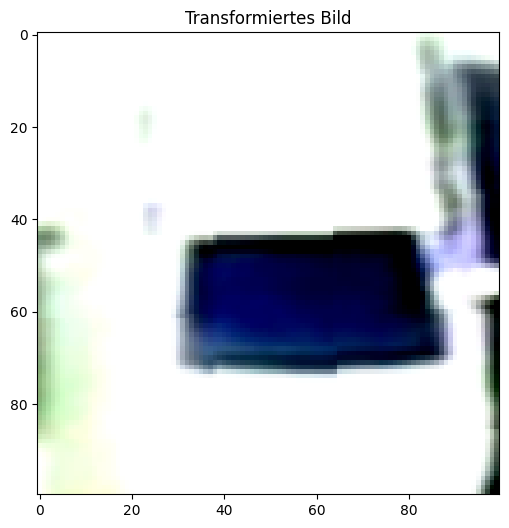

In [22]:
trainBatch = next(iter(train_loader))
# Ehy do we need to transpose, multiply etc.
image = (trainBatch[0][0].numpy().transpose((1, 2, 0)) * 255).astype('uint8') # transpose and 255 are mandatory here.

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Transformiertes Bild')
plt.show()

/var/folders/2n/6g_5z31502qdn2b96gy2sss00000gn/T/ipykernel_38954/1398652368.py:15: RuntimeWarning: invalid value encountered in cast
  image = (batch[i].numpy().transpose((1, 2, 0)) * 255).astype('uint8')


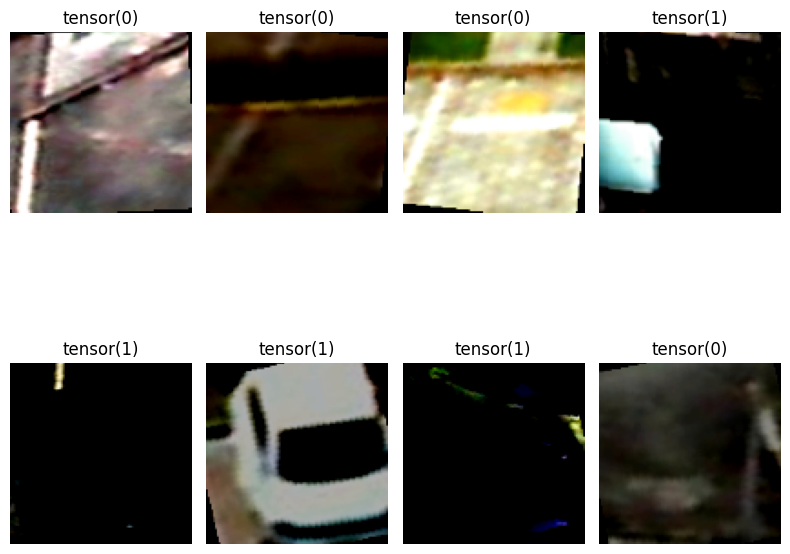

In [26]:
# Vizualize 8 pictures from one batch.
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(8, 8))
	# loop over the batch size
	for i in range(0, 8):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		# Convert the image from BGR to RGB (OpenCV uses BGR by default)
		
		image = (batch[i].numpy().transpose((1, 2, 0)) * 255).astype('uint8')
		label = classes[i]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()
 
trainBatch, classes = next(iter(train_loader))
visualize_batch(trainBatch, classes, "train")

### Testing of loaded models


In [6]:
def test_on_new_data(model, path):
    '''
    Tests a trained model on new data. Shows metrics to the model.
    Input: 
    Model - loaded model including the trained weights
    path - path to the datafolder. Labels must be subfolders.
    
    '''
    #device = torch.device("mps")
    # Count data
    total = 0
    numfiles = []
    for root, dirs, files in os.walk(path):
        total += len(files)
        numfiles.append(len(files))
    print('Data size:', total)
    print(f'Class Empty: {numfiles[1]}, Class Occupied: {numfiles[2]}')  
    
    
    # Transformer for test data
    data_transform_test = transforms.Compose([
    transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    # Defining the dataset.
    dataset = ImageFolder(path, transform=data_transform_test)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    all_predictions = []
    all_labels = []
    misclassified_images = [] # List for misclassified images.

    # Making predictions
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            misclassified_mask = predictions != labels
            misclassified_indices = (torch.nonzero(misclassified_mask)).squeeze(dim=1)

            for mis_idx in misclassified_indices:
                misclassified_images.append(loader.dataset.imgs[i * loader.batch_size + mis_idx])

    # Evaluation of metrics
    print(f'{model._get_name()} Performance in Classification:')
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    roc_auc = roc_auc_score(all_labels, all_predictions)
    f1score = f1_score(all_labels, all_predictions)
    print("\nROC-AUC Score:", roc_auc)
    print("\nf1- Score:", f1score)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
    
    return misclassified_images

    
    

## Baseline model
- metric: accuracy.
- track params.
- track artifacts

### Train ResNet18 model

Why ResNet18?  
ResNet18 ist eine spezielle Variante des ResNet (Residual Network) und wurde für die Bildklassifizierung entwickelt. Hier sind einige Gründe, warum ResNet18 eine beliebte Wahl ist:

Residual Learning (Skip Connections): Das ResNet-Design enthält sogenannte "Skip Connections" oder "Residual Connections". Diese ermöglichen es, das Modell tiefer zu machen, indem sie "Sprung"-Verbindungen über Schichten hinweg einführen. Dies erleichtert das Training von tieferen Netzen, indem es das Problem des Verschwindens von Gradienten lindert.

Leistung trotz geringerer Komplexität: ResNet18 hat im Vergleich zu tieferen Varianten wie ResNet50 eine geringere Modellkomplexität. Dies macht es effizienter und schneller zu trainieren, insbesondere wenn die verfügbare Datenmenge begrenzt ist.

Gute allgemeine Leistung: ResNet18 hat sich als robustes Modell für verschiedene Bildklassifizierungsaufgaben bewährt. Es bietet eine gute Balance zwischen Modellgröße und Leistung.

Bewährte Architektur: ResNet-Architekturen wurden in verschiedenen Herausforderungen und Wettbewerben erfolgreich eingesetzt, einschließlich des ImageNet Large Scale Visual Recognition Challenge. Die Architektur hat sich als effektiv für die Merkmalsextraktion und Klassifizierung in Bildern erwiesen.

Verfügbarkeit von vortrainierten Modellen: Da ResNet-Modelle weit verbreitet sind, sind vortrainierte Gewichte für ResNet18 verfügbar. Dies ermöglicht den Transfer von Wissen (Transfer Learning), was besonders nützlich ist, wenn nur begrenzte Daten für das Training verfügbar sind.

Ressourceneffizienz: ResNet18 ist weniger rechenintensiv als tiefere Varianten und eignet sich daher besser für Anwendungen mit begrenzten Ressourcen, wie etwa auf mobilen Geräten oder Edge-Geräten.

Insgesamt wird ResNet18 aufgrund seiner effektiven Architektur, seiner guten Leistung und seiner Verfügbarkeit von vortrainierten Modellen häufig für Bildklassifizierungsaufgaben verwendet.

In [ ]:
# Define model (Beispiel: ResNet18)
model = models.resnet18(pretrained=True)
# Adapt last layer to our problem
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes (Empty, Occupied)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialization of Mlflow
import mlflow
from datetime import datetime

# Experiment name
experiment_name = "ResNet_first_try" + datetime.now().strftime("%Y%m%d%H%M%S")
# Starten Sie das MLflow-Run
mlflow.set_experiment(experiment_name)
mlflow.start_run()

# Training d
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

# Save the model in MLflow
mlflow.pytorch.log_model(model, artifact_path="ResNet_first_try")

# End the MLflow run
mlflow.end_run()

2024/01/11 15:58:40 INFO mlflow.tracking.fluent: Experiment with name 'ResNet_first_try20240111155840' does not exist. Creating a new experiment.


### Load the trained ResNet18 model

In [4]:
# Load of the model after it was saved with the inference way. torch.save(model.state_dict(), PATH)
loaded_model = models.resnet18()
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 2)
loaded_model.load_state_dict( torch.load('../models/resnet18_sunny_datasets.pth'))
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
file_path = '../models/resnet18_sunny_datasets.bin'

# Save the model to the specified file path
torch.save(loaded_model.state_dict(), file_path)



Data size: 7959
Class Empty: 5607, Class Occupied: 2351


ResNet Performance in Classification:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5607
           1       1.00      0.99      0.99      2351

    accuracy                           1.00      7958
   macro avg       1.00      0.99      0.99      7958
weighted avg       1.00      1.00      1.00      7958


ROC-AUC Score: 0.9928033614177211

Confusion Matrix:


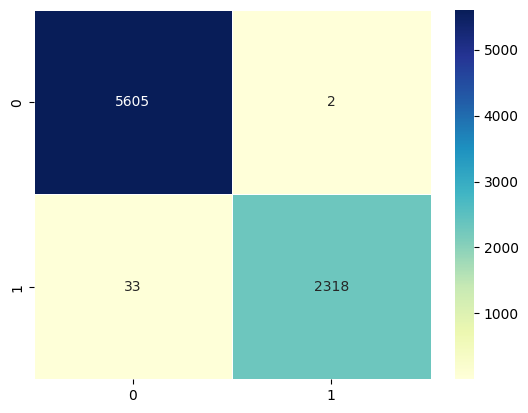

In [34]:
# Loaded Resnet needs 9min on 04_cloudy data.
# Loaded Resnet needs 2min on 04_rainy data.

test_on_new_data(loaded_model, destpath_dic['04_rainy'])

## MobileNet
- MobileNet paper metrics: Accuracy and Auc Score.

In [ ]:
#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")
   
# Check if GPU is available.
print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built()) #MPS is activated
print(torch.cuda.is_available()) 

tensor([1.], device='mps:0')
True
True
False


In [ ]:
# Helper function to save confusion matrix as a text file
def save_confusion_matrix(cm, epoch):
    filename = f"confusion_matrix_epoch_{epoch}.txt"
    with open(filename, "w") as file:
        file.write("Confusion Matrix:\n")
        file.write(str(cm))
    return filename

### Training

In [112]:
# See the classifier of the model.
model = models.mobilenet_v3_large(pretrained = True)
#model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
#model.classifier
model.eval()

/Users/margarita.samuseva/neuefische/pklot/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/margarita.samuseva/neuefische/pklot/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [107]:
## Train Model
# Training 49 min on 10% of sunny data.
# Training 172 min on 50% of sunny data.
# Training 209 min on 70% of sunny data.
# 458min

mlflow.end_run()
# With Batchsize 8. Took 853 = 14.2h Minutes to run through the first epoch of traindata.
# To read val dataset and make predictions and to save them takes 14.5 min.

# Setting to use GPU instead of CPU.
device = mps_device
# Modell definieren (Beispiel: ResNet18)
model = models.mobilenet_v3_large(pretrained = True).to(device)  
# Modification of the classifier part.
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2) # model.classifier[3] refers to the layer of the classifier. ...
# MobileNet_V3 classifier consists of 4 layers. See field above. with in_features, we retreive the dimension of the input. 
model.to(device)
# Loss-Funktion und Optimizer wählen
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Experimentname for MLFlow
experiment_name = "MobilenetV3_large_0.5sunny"
# Starten Sie das MLflow-Run
mlflow.set_experiment(experiment_name)
mlflow.start_run()

# Training
num_epochs = 10
for epoch in range(num_epochs):
    # Trainingsphase
    model.train()
    all_labels=[]
    all_predictions = []
    
    for inputs_train, labels_train in train_loader:
        # Move input and label tensors to the default device
        inputs_train, labels_train = inputs_train.to(device), labels_train.to(device)
        optimizer.zero_grad() #sets the gradients from previous step to0, os that there is no accumulation.
        outputs = model(inputs_train)
        loss = criterion(outputs, labels_train) # An error "target 4 is out of bounds" indicates that the class4 is out of bounds, doesnt exist.
        # Usually it is the case when the dataloader is created with wrong number of classes.
        loss.backward()
        optimizer.step()
        
        _, predictions = torch.max(outputs, 1)
        all_labels.extend(labels_train.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
    
    mlflow.log_metric("train_accuracy_epoch", accuracy_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("train_roc_auc",roc_auc_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("train_precision", precision_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("train_recall", recall_score(all_labels, all_predictions), step=epoch)

    # Validate
    model.eval()
    val_loss = 0.0
    corrects = 0
    total = 0
    
    all_labels=[]
    all_predictions = []
    
    with torch.no_grad(): # no Gradients should be updated.
        for inputs_val, labels_val in val_loader:
            # Move input and label tensors to the default device
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            
            outputs = model(inputs_val)
            loss = criterion(outputs, labels_val)
            val_loss += loss.item()
            
            # Lists for epoch metrics
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels_val.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_predictions)
    mlflow.log_metric("val_accuracy", accuracy_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("val_roc_auc",roc_auc_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("val_precision", precision_score(all_labels, all_predictions), step=epoch)
    mlflow.log_metric("val_recall", recall_score(all_labels, all_predictions), step=epoch)
    mlflow.log_artifact(save_confusion_matrix(cm, epoch))


        
torch.save(model, '../models/mobilenetv3_large_0.5sunny_try2.pth')
torch.save(model.state_dict(), '../models/mobilenetv3_large_0.5sunny_states_try2.pth')

# Speichern Sie das Modell in MLflow
mlflow.pytorch.log_model(model, artifact_path="MobilenetV3_large_0.5sunny")

# Beenden Sie den MLflow-Run
mlflow.end_run()

/Users/margarita.samuseva/neuefische/pklot/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/margarita.samuseva/neuefische/pklot/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /Users/margarita.samuseva/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100.0%
2024/01/22 17:08:40 INFO mlflow.tracking.fluent: Experiment with name 'MobilenetV3_large_0.5sunny' do

### Test on testset from the original loader.

In [19]:
# Took 12.5min trained model on test data.
# Took 53.5min loaded model on test data.
all_predictions = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs_test, labels_test in val_loader:
        #inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs = loaded_model(inputs_test)
        
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels_test.cpu().numpy())
    

In [46]:
testlabels = all_labels
testlabels_pred = all_predictions

0.9989639000981568
0.9989562803124716
0.9989835767399561


18338

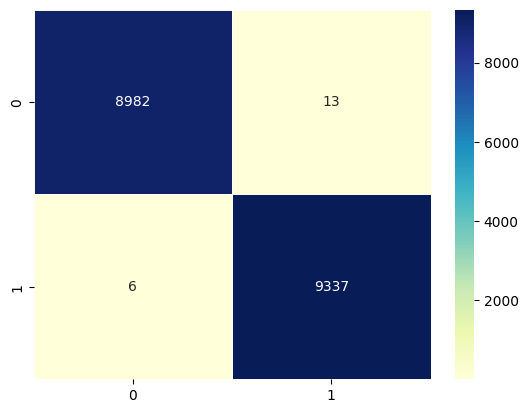

In [20]:
print(accuracy_score(all_labels, all_predictions))
print(roc_auc_score(all_labels, all_predictions))
print(f1_score(all_labels, all_predictions))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
len(all_labels)

### Test on completely new data

In [1]:
loaded_model = models.mobilenet_v3_large()
loaded_model.classifier[3] = nn.Linear(loaded_model.classifier[3].in_features, 2) 
loaded_model.load_state_dict(torch.load('../models/mobilenetv3_large_0.5sunny_states.pth'))
loaded_model.eval()


Data size: 99891
Class Empty: 42306, Class Occupied: 57584
MobileNetV3 Performance in Classification:
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.59      0.53     42306
           1       0.64      0.54      0.58     57584

    accuracy                           0.56     99890
   macro avg       0.56      0.56      0.55     99890
weighted avg       0.57      0.56      0.56     99890


ROC-AUC Score: 0.5601815393121421

f1- Score: 0.5818226428982607

Confusion Matrix:


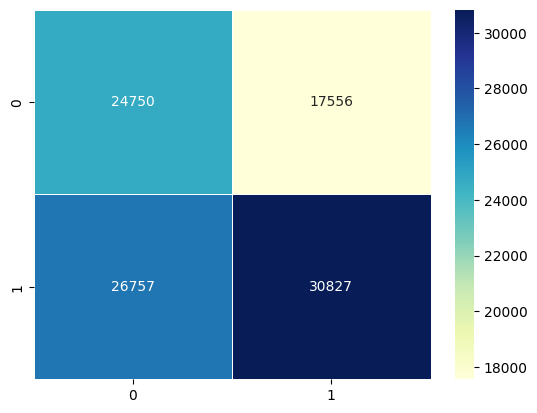

In [10]:
# Test works only on loaded model. Because during the training the model was assigned to GPU. New GPU Tensors were created.
# Loaded model on rainy data needs 1.5min. Trafo: Resize and normalize.
# MobileNet traiend on 10% of sunny data on Puc_Sunny took 39min
# MobileNet traiend on 10% of sunny data on Puc_cloudy took 22min
# MobileNet traiend on 10% of sunny data on Puc_rainy took 14min
# MobileNet traiend on 10% of sunny data on 04_cloudy took 6min
# MobilrNet traine on 50 of mixed data on Puc_rainy took 112min.
misclassified= test_on_new_data(loaded_model, destpath_dic['05_sunny'])

Data size: 56967
Class Empty: 23202, Class Occupied: 33764
MobileNetV3 Performance in Classification:
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.49      0.46     23202
           1       0.61      0.54      0.57     33764

    accuracy                           0.52     56966
   macro avg       0.51      0.52      0.51     56966
weighted avg       0.53      0.52      0.52     56966


ROC-AUC Score: 0.5152229943717295

f1- Score: 0.5700871476799876

Confusion Matrix:


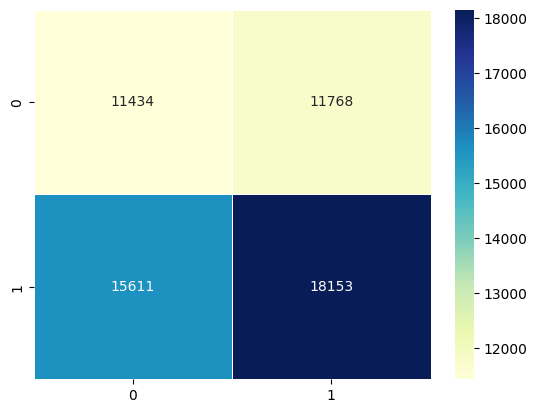

In [9]:
#model._get_name()
# Test script with trained model on rainy data (7959 pics) needs 13s.Trafo: Resize and normalize.
# Script without using GPU doesn't work for the model that comes out from training. Only works if I load the model. Why?
misclassified = test_on_new_data(loaded_model, destpath_dic['PUC_cloudy'])

### Error analysis

In [119]:
misclassified

[('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2012-12-08_18_35_15#008.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2012-12-08_19_05_15#014.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2012-12-26_16_10_12#003.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2012-12-26_16_40_13#021.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2012-12-26_19_40_16#016.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2012-12-26_20_10_17#012.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2012-12-28_09_30_04#019.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Empty/2013-01-17_07_55_03#006.jpg',
  0),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Occupied/2012-12-11_16_06_08#016.jpg',
  1),
 ('../data/PKLot/PKLotSegmented_rearranged/UFPR04/Rainy/Occupied/2013-01-17_09_55_05#002.jpg',
  1)]

In [117]:
def visualize_missclassified(misclassified): 
    data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128), interpolation=Image.BICUBIC),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]) 
    # initialize a figure
    fig = plt.figure(figsize=(10,10))
	# loop over the batch size
    # Definition der Transformationen

    for i in range(0, 10):
		# create a subplot
        ax = plt.subplot(2, 5, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		# Convert the image from BGR to RGB (OpenCV uses BGR by default
        # Anwendung der Transformationen
        image = cv2.imread(misclassified[i][0])
        idx = i
        label = misclassified[i][1]
        transformed_image = data_transform(image)

        # Umwandlung von Tensor in NumPy-Array und Rückkehr der Werte auf den Bereich [0, 255]
        transformed_image = (transformed_image.numpy().transpose((1, 2, 0)) * 255).astype('uint8')
        
		# show the image along with the label
        plt.imshow(transformed_image)
        plt.title(f'Label: {label}, Index: {i}')
        plt.axis("off")
	# show the plot
    plt.tight_layout()
    plt.show()
 

/var/folders/2n/6g_5z31502qdn2b96gy2sss00000gn/T/ipykernel_8799/4121641751.py:28: RuntimeWarning: invalid value encountered in cast
  transformed_image = (transformed_image.numpy().transpose((1, 2, 0)) * 255).astype('uint8')


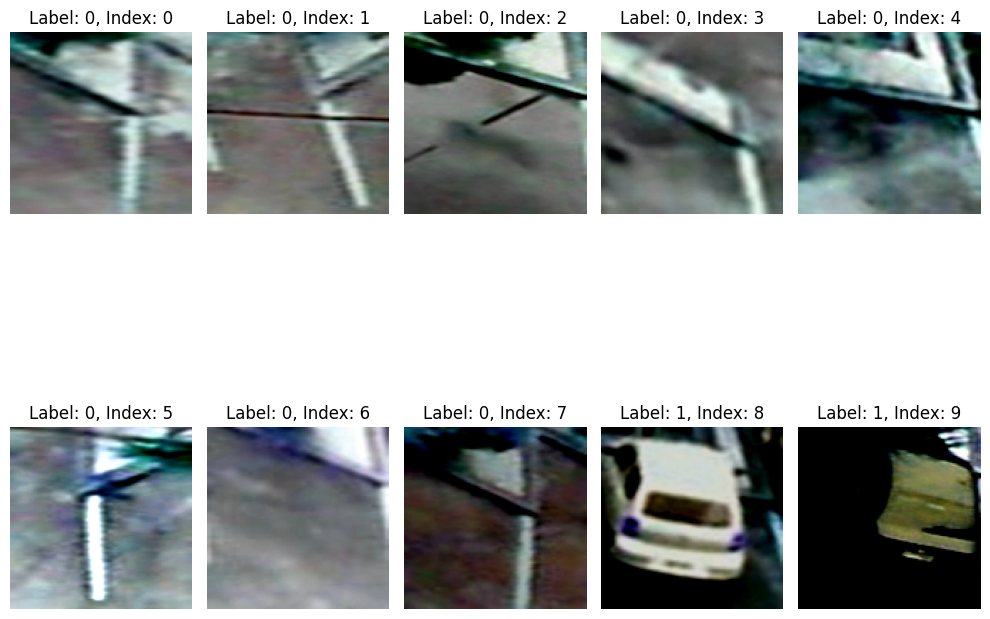

In [118]:
visualize_missclassified(misclassified)

# Activation map

In [134]:
loaded_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

/var/folders/2n/6g_5z31502qdn2b96gy2sss00000gn/T/ipykernel_39363/62371316.py:48: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * activation_map_resized)


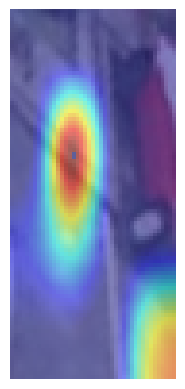

In [15]:
# Load a pre-trained CNN model (e.g., ResNet)
model = loaded_model

# Load and preprocess an example image
#image_path = '../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/Empty/2012-09-11_15_16_58#002.jpg'
#image_path = '../data/PKLot/PKLotSegmented_rearranged/PUC/Sunny/Occupied/2012-09-11_15_16_58#001.jpg'
image_path = '../data/PKLot/PKLotSegmented_rearranged/UFPR04/Sunny/Empty/2012-12-07_17_17_25#007.jpg'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((INPUT_HEIGHT, INPUT_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
input_image = transform(image).unsqueeze(0)

# Hook into a specific layer
activation = {}

def hook_fn(module, input, output):
    activation['value'] = output.detach()

# Register the hook to the desired layer (e.g., the last convolutional layer)
target_layer = model.features[-1] # Example: Last layer of the last block in ResNet50
hook = target_layer.register_forward_hook(hook_fn)

# Perform Forward Pass
model.eval()
with torch.no_grad():
    model(input_image)

# Unregister the hook after the forward pass
hook.remove()

# Visualize Activation Map on Original Image
activation_map = activation['value'].squeeze().mean(dim=0).numpy()
activation_map = np.maximum(activation_map, 0)
activation_map /= np.max(activation_map)
#activation_map = np.interp(activation_map, (activation_map.min(), activation_map.max()), (0, 1))  # Normalize to [0, 1]

# Convert the PIL image to a NumPy array
original_image_array = np.array(image)

# Resize activation map to match the original image size
#activation_map_resized = cv2.resize(activation_map, (original_image_array.shape[1], original_image_array.shape[0]))
activation_map_resized = np.array(Image.fromarray(activation_map).resize(original_image_array.shape[1::-1]))

# Blend the original image with the normalized activation map
heatmap = np.uint8(255 * activation_map_resized)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR) # Transformation to BGR because cv2 expects a picture in BGR.
heatmap =  cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
 # Is this transformation necessary?
blended_image = 0.5 * original_image_array + 0.5 * heatmap

# Display the blended image
plt.imshow(blended_image.astype(np.uint8))
plt.axis('off')
plt.show()
